In [1]:
import torch
from torch import nn
from torchvision.transforms import  transforms
from data import ZSSRDataset, ZSSRSampler
from metrics import psnr_fn
from model import ZSSRModel
import torch.nn.functional as F
from transforms import  ToTensor, RandomCrop
from train_and_eval import train_single_img, test_single_img
import numpy as np
from PIL import  Image


In [2]:
crop_size = 128
num_batches = 15000
sr_factor = 2
learning_rate = 0.00001
device = "cuda"

hr_path = "./data/BSD100/img_013.png"
hr_img = Image.open(hr_path)
lr_path = "./data/BSD100/unknown_kernel_sr2/img_013.png"
lr_img = Image.open(lr_path)

Create the dataset and the sampler by probability

In [3]:
dataset = ZSSRDataset.from_image(lr_img, sr_factor)
data_sampler = ZSSRSampler(dataset)

Show sample of the dataset created by the low resolution image.
<br>
Note that these picture are before the random crop transformation 

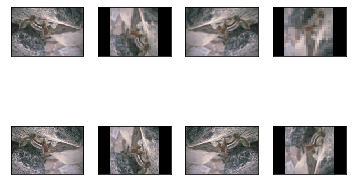

In [4]:
# show sample of the augmented LR-HR sons pairs 
# The first raw is the low resolution images
# The second raw is the high resolution images
dataset.show_pairs()

In [5]:
def bicubic_upsample(lr, scale):
    lr = lr.resize([lr.size[0] * scale, lr.size[1] * scale],
                   resample=Image.BICUBIC)
    return transforms.ToTensor()(lr)

trans = transforms.Compose([
    ToTensor(),
    RandomCrop(128)
])

Training

In [6]:
loss_fn = F.l1_loss
model = ZSSRModel()
model.train()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(f"Starting training")
train_single_img(lr_img,
                 model,
                 bicubic_upsample,
                 data_sampler,
                 trans,
                 optimizer,
                 num_batches)

Starting training
Done training.
Avg training loss is 0.02739221440719683


Evaluation

In [7]:
model.eval()
psnr = test_single_img(model, bicubic_upsample, lr_img, hr_img, sr_factor)["psnr"]
print(f"PSNR value is {psnr}")

PSNR value is 33.477392762717685


Original high resolution image

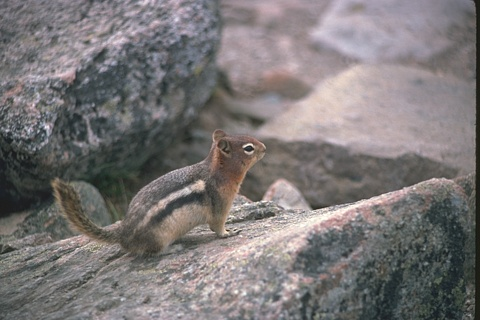

In [8]:
hr_img

Original low resolution image

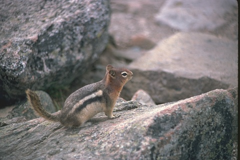

In [9]:
lr_img

Model prediction

In [10]:
hr_predict = model(bicubic_upsample(lr_img, 2).to(device).unsqueeze(0)).squeeze(0)
hr_numpy = hr_predict.permute(1,2,0).detach().cpu().numpy()
hr_numpy[np.where(hr_numpy < 0)] = 0.0
hr_numpy[np.where(hr_numpy > 1)] = 1.0

In [11]:
hr_predict = model(bicubic_upsample(lr_img, 2).to(device).unsqueeze(0)).squeeze(0)
hr_predict_numpy = hr_predict.permute(1,2,0).detach().cpu().numpy()
hr_predict_numpy[np.where(hr_predict_numpy < 0)] = 0.0
hr_predict_numpy[np.where(hr_predict_numpy > 1)] = 1.0

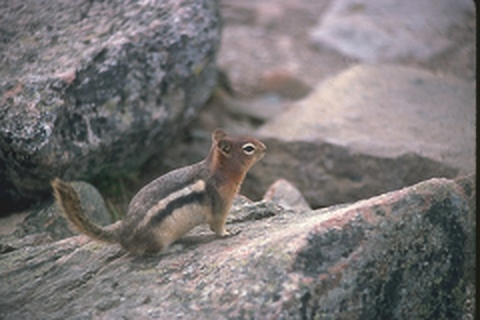

In [12]:
import numpy as np
Image.fromarray(np.uint8(hr_predict_numpy * 255))